## A (very) brief introduction to Color Doppler 

Color doppler is a medical imaging modality for blood flow imaging.  
It bases on the Doppler effect.  
Doppler effect is a shift of a received signal frequency, when the wave source is moving relatively to the receiver.  
In medicine 'sources' (i.e. moving tissue, specifically blood) do not emits acoustic waves, but are 'iluminated' by a ultrasound pulses produced by a probe.  
It can be shown [Evans2000] that the shift in the received frequency is given by following equation:

$
f_d = f_t - f_r = \frac{2f_tv\cos{\alpha}}{c}
$

where
* $f_d$ - frequency shift, or doppler frequency,
* $f_t$ - transmitted frequency, 
* $f_r$ - received frequency, 
* $v$ - speed of the blood,
* $\alpha$ - the angle between the ultrasound beam and the direction of motion of the blood,
* $c$ - speed of sound in the medium. It is usually assumed that in soft tissue $c = 1540 [m/s]$.



<!-- When the medical probe transmits the ultrasound pulse, and it is scattered on moving blood (i.e. on blood cells), the received echoes changes in phase.    -->
In classical approach the probe transmits a series of (quite long) ultrasound pulses, receiving echoes after each transmit.  
The series consists of $N$ transmit/receive (TR) events, and the higher $N$, the higher sensitivity, but lower doppler framerate.  
Typically $N$ could be in the range of $8-16$ for classical methods and $32-256$ for synthetic aperture methods, however there are no strict rules.  
The TR events in the series are repeated with constant Pulse Repetition Frequency (PRF).  
Thus the time between TR events - Pulse Repetition Interval (PRI) is equal $\frac{1}{PRF}$.  
The received signals are IQ demodulated. Then, the high-pass filter in 'slow time' (the so-called wall clutter filter) is used.  
This filter is used for removing the constant echoes from non-flowing medium.  
The $f_d$ can be estimated from high-pass filtered IQ signal by means of autocorrelation esitmator:  

$
\overline{f_d} = \frac{1}{2\pi{}PRI} 
    \tan^{-1}{\left\{ 
        \frac{\sum^{N}_{i=1}{Q(i)I(i-1) - I(i)Q(i-1)}}
             {\sum^{N}_{i=1}{I(i)I(i-1) + Q(i)Q(i-1)}}
    \right\}}
$



<!-- , and next the phase is estimated for each sample.  
Then, for each sample the phase changes $\Delta{\theta}$ from TR to TR are calculated. Sometimes it is refered as phase changes in 'slow time'.  
The doppler frequency (averaged over time) can be calculated from the formula

$
\overline{f_d} = \frac{1}{N-1} \sum_{n=1}^{N-1} \frac{\Delta{\theta}_{n}}{PRI}
$

 -->
Then, we can use the following formula to estimate (average) speed of the blood flow.  

$
v_s = \frac{\overline{f_d}}{f_t} \frac{c}{2\cos{\alpha}}
$





--------------------------------------------------------------------------------

In [1]:
import cupy as cp
import numpy as np
import scipy.signal as spsig
import matplotlib.pyplot as plt

In [2]:
def dB(data):
    return 20*np.log10(data)

def iq2bmode(iq):
    env = np.abs(iq)
    mx = np.nanmax(env)
    env = env/mx
    env = dB(env)
    return env

def show_bmode(xgrid, zgrid, img, title='bmode'):
    # convert grid from [m] to [mm]
    xgrid = xgrid*1e3
    zgrid = zgrid*1e3
    extent = (min(xgrid), max(xgrid), min(zgrid), max(zgrid))
    
    # calculate data aspect for proper image proportions
    dx = xgrid[1]-xgrid[0]
    dz = zgrid[1]-zgrid[0]
    data_aspect = dz/dx
    
    fig, axes = plt.subplots()
    axes.imshow(img,
                interpolation='bicubic',
                aspect=data_aspect,
                cmap='gray',
                extent=extent
                  )
    plt.xlabel('[mm]')
    plt.ylabel('[mm]')
    plt.title(title)
    
def show_doppler(xgrid, zgrid, color, power, doppler_type='color', power_threshold=20):
    # convert grid from [m] to [mm]
    xgrid = xgrid*1e3
    zgrid = zgrid*1e3
    extent = (min(xgrid), max(xgrid), min(zgrid), max(zgrid))
    
    # calculate data aspect for proper image proportions
    dx = xgrid[1]-xgrid[0]
    dz = zgrid[1]-zgrid[0]
    data_aspect = dz/dx
    
    if doppler_type == 'color':
        cmap = 'bwr'
        title = 'color doppler'
        img = color
        img[power < power_threshold] = None
        
    elif doppler_type == 'power':
        cmap = 'hot'
        title = 'power doppler'
        img = dB(power)
        img[power < power_threshold] = None
        
    else:
        raise ValueError("The 'imgtype' parameter should be one of the following: "
                         "'bmode', 'color', 'power'. ")
    
    fig, axes = plt.subplots()
    axes.imshow(img,
                interpolation='bicubic',
                aspect=data_aspect,
                cmap=cmap,
                extent=extent
                  )
    plt.xlabel('[mm]')
    plt.ylabel('[mm]')
    plt.title(title)
    
def show_blend(xgrid, zgrid, bmode, color, power, 
               doppler_type='color', 
               power_threshold=20, 
               color_limit=(-1.5, 1.5)):
    
    # convert grid from [m] to [mm]
    xgrid = xgrid*1e3
    zgrid = zgrid*1e3
    extent = (min(xgrid), max(xgrid), min(zgrid), max(zgrid))
    
    # calculate data aspect for proper image proportions
    dx = xgrid[1]-xgrid[0]
    dz = zgrid[1]-zgrid[0]
    data_aspect = dz/dx
    
    if doppler_type == 'color':
        cmap = 'bwr'
        title = 'color doppler'
        img = np.copy(color)
        img[power < power_threshold] = None
        vmin = color_limit[0]
        vmax = color_limit[1]
        
    elif doppler_type == 'power':
        cmap = 'hot'
        title = 'power doppler'
        img = dB(power)
        img[power < power_threshold] = None
        vmin = None
        vmax = None
        
    else:
        raise ValueError("The 'imgtype' parameter should be one of the following: "
                         "'bmode', 'color', 'power'. ")
    
    fig, axes = plt.subplots()
    axes.imshow(bmode,
                interpolation='bicubic',
                aspect=data_aspect,
                cmap='gray',
                extent=extent)
    
    axes.imshow(img,
                interpolation='bicubic',
                aspect=data_aspect,
                cmap=cmap,
                extent=extent,
                vmin=vmin, vmax=vmax
               )    
    
    plt.xlabel('[mm]')
    plt.ylabel('[mm]')
    plt.title(title)
    plt.show
        
def filter_wall_clutter(input_signal, Wn=0.2, N=32):
    sos = spsig.butter(N, Wn, 'high', output='sos')
    output_signal = spsig.sosfiltfilt(sos, input_signal, axis=0)
    return output_signal.astype(np.complex64)


#### Kernel definitions

In [3]:
source = r"""

#include <cupy/complex.cuh>
extern "C" __global__ 
void dopplerColor(float *color, 
                  float *power, 
                  const complex<float> *iqFrames, 
                  const int nz, 
                  const int nx, 
                  const int nFrames)
                  
{
    int z = blockIdx.x * blockDim.x + threadIdx.x;
    int x = blockIdx.y * blockDim.y + threadIdx.y;

    
    if (z>=nz || x>=nx) {
        return;
    }
    
    /* Color estimation */
        
    complex<float> iqCurrent, iqPrevious;
    float ic, qc, ip, qp, pwr, nom = 0.0f, den = 0.0f;
    
    iqCurrent = iqFrames[z + x*nz];
    pwr = real(iqCurrent)*real(iqCurrent) +  
          imag(iqCurrent)*imag(iqCurrent);
    
    for (int iFrame=1; iFrame<nFrames; iFrame++) {
    
        iqPrevious = iqCurrent;
        iqCurrent = iqFrames[z + x*nz + iFrame*nz*nx];
        
        ic = real(iqCurrent);
        qc = imag(iqCurrent);
        ip = real(iqPrevious);
        qp = imag(iqPrevious);
        
        pwr += ic*ic + qc*qc;
        den += ic*ip + qc*qp;
        nom += qc*ip - ic*qp;
    }
    color[z + x*nz] = atan2f(nom, den);
    power[z + x*nz] = pwr/nFrames;
    
    //color[z + x*nz] = abs(iqFrames[z + x*nz]); 
    //color[z + x*nz] = iqFrames[z + x*nz]; 
}

"""
cdoppler = cp.RawKernel(source, 'dopplerColor')


## Data processing for Color Doppler

#### Data loading

In [4]:
from scipy.io import loadmat

# this is iq data aquired from carotid artery
data = loadmat('./data/iqImgML_batch01.mat')
# print(data.keys())

c = np.squeeze(data['sos']) # speed of sound
prf = np.squeeze(data['prf']) # speed of sound
iq = data['iq']
iq = np.ascontiguousarray(iq.T)
xgrid = np.squeeze(data['xGrid'])
zgrid = np.squeeze(data['zGrid'])


#### Color doppler estimation using defined kernel

In [5]:
# apply wall clutter filter
iq_wcf = filter_wall_clutter(iq)

In [6]:
# push input data to gpu 
iq_gpu = cp.array(iq_wcf)

# allocate memory on gpu for output data
nframes, nx, nz = iq.shape
color =  cp.zeros((nx, nz)).astype(cp.float32)
power =  cp.zeros((nx, nz)).astype(cp.float32)

# specify block and grid sizes
bx = 16
bz = 16
gx = np.ceil(nx/bx).astype(int)
gz = np.ceil(nz/bx).astype(int)
block = (bz, bx)
grid = (gz, gx)

# use kernel (and working time)
%time cdoppler(grid, block, (color, power, iq_gpu, nz, nx, nframes))

# get data from gpu
color = color.get().T
power = power.get().T

CPU times: user 406 µs, sys: 79 µs, total: 485 µs
Wall time: 489 µs


#### Presentation of results 

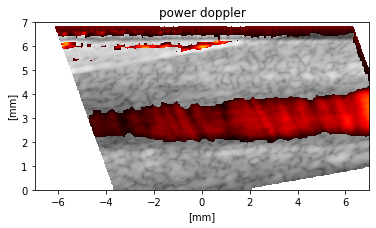

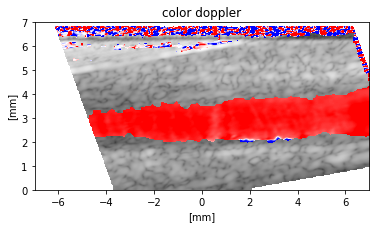

In [7]:
center_frame = np.round(nframes/2).astype(int)
bmode = iq2bmode(iq[center_frame,:,:]).T
# show_doppler(xgrid, zgrid, color, power, 'color')
# show_doppler(xgrid, zgrid, color, power, 'power')
# show_bmode(xgrid, zgrid, bmode)
show_blend(xgrid, zgrid, bmode, color, power, 'power')
show_blend(xgrid, zgrid, bmode, color, power, 'color', color_limit=(-1,1))

## A very brief introduction to Vector Doppler 

## The complete processing for Vector Doppler using CUDA

## Doing B-mode and Color/Vector processing in the same time - a single GPU (multiple streams) example

### References

[Evans2000] Evans, David H., and W. Norman McDicken. Doppler ultrasound: physics, instrumentation and signal processing. Wiley-Blackwell, 2000.